# 📘 Notebook 6: Ternary Target (Up/Down/Neutral) Strategy

## Objective
Build a complete trading strategy using **ternary classification** target:
- **+1**: Stock goes UP significantly
- **0**: Stock stays NEUTRAL (within noise band)
- **-1**: Stock goes DOWN significantly

## Why Ternary?
- Filters out noise (small moves are "neutral")
- Classification often more stable than regression
- Aligns with practical trading: only trade when signal is strong

## Pipeline (Following NB3/NB4 Methodology)
1. **Load Data** - Features + ternary target
2. **Walk-Forward Training** - Same methodology as NB3
3. **IC Analysis** - Daily IC, regime IC, stability
4. **Weakness Diagnosis** - Find and fix issues
5. **Signal Construction** - Convert predictions to tradeable signals
6. **Backtesting** - Full IS/OOS evaluation

---

In [1]:
# =============================================================================
# CELL 1: IMPORTS & CONFIGURATION
# =============================================================================

import sys
from pathlib import Path
import importlib

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Set seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Directories
DATA_DIR = PROJECT_ROOT / "data" / "processed"
TARGET_DIR = PROJECT_ROOT / "data" / "processed" / "targets"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "ternary_strategy"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*70)
print("📘 NOTEBOOK 6: TERNARY TARGET STRATEGY")
print("="*70)
print(f"\nProject root: {PROJECT_ROOT}")
print(f"Output dir: {OUTPUT_DIR}")

📘 NOTEBOOK 6: TERNARY TARGET STRATEGY

Project root: c:\Users\ponna\OneDrive\Desktop\Precog Task
Output dir: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\ternary_strategy


---
## Stage 1: Load Data

In [2]:
# =============================================================================
# CELL 2: LOAD FEATURES & TERNARY TARGET
# =============================================================================

print("📂 Loading data...")

# Load aligned features (long format: date, ticker, features)
features_is = pd.read_parquet(DATA_DIR / 'features_aligned_is.parquet')
print(f"   Features: {features_is.shape}")

# Load TERNARY target (wide format: dates x assets)
target_wide = pd.read_parquet(TARGET_DIR / 'sign_ternary_is.parquet')
print(f"   Ternary target (wide): {target_wide.shape}")

# Load raw returns for PnL calculation
raw_returns_wide = pd.read_parquet(TARGET_DIR / 'raw_return_is.parquet')
print(f"   Raw returns (wide): {raw_returns_wide.shape}")

# Load feature names
with open(DATA_DIR / 'feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]
print(f"   Loaded {len(feature_names)} feature names")

# Convert target to long format
target_long = target_wide.stack().reset_index()
target_long.columns = ['date', 'ticker', 'target']
print(f"   Target (long): {target_long.shape}")

# Convert raw returns to long format  
returns_long = raw_returns_wide.stack().reset_index()
returns_long.columns = ['date', 'ticker', 'forward_return']
print(f"   Returns (long): {returns_long.shape}")

# Merge features with target and returns
panel_is = features_is.merge(target_long, on=['date', 'ticker'], how='inner')
panel_is = panel_is.merge(returns_long, on=['date', 'ticker'], how='inner')
print(f"   Merged panel: {panel_is.shape}")

# Ensure date is datetime
panel_is['date'] = pd.to_datetime(panel_is['date'])

# Check target distribution
print(f"\n📊 Ternary Target Distribution:")
target_dist = panel_is['target'].value_counts().sort_index()
for val, count in target_dist.items():
    pct = count / len(panel_is) * 100
    label = {-1: 'DOWN', 0: 'NEUTRAL', 1: 'UP'}.get(val, str(val))
    print(f"   {label:>8} ({val:>2}): {count:>7,} ({pct:>5.1f}%)")

📂 Loading data...
   Features: (199800, 43)
   Ternary target (wide): (1998, 100)
   Raw returns (wide): (1998, 100)
   Loaded 41 feature names
   Target (long): (199800, 3)
   Returns (long): (198900, 3)
   Merged panel: (198900, 45)

📊 Ternary Target Distribution:
       DOWN (-1.0):  72,574 ( 36.5%)
    NEUTRAL (0.0):  28,102 ( 14.1%)
         UP (1.0):  98,224 ( 49.4%)


In [3]:
# =============================================================================
# CELL 3: DATA INTEGRITY & TIMELINE
# =============================================================================

print("\n🔍 Data Integrity Check...")

# Check for missing values
missing_features = panel_is[feature_names].isna().sum().sum()
missing_target = panel_is['target'].isna().sum()
missing_returns = panel_is['forward_return'].isna().sum()

print(f"   Missing features: {missing_features:,}")
print(f"   Missing target: {missing_target:,}")
print(f"   Missing returns: {missing_returns:,}")

# Drop missing
panel_is = panel_is.dropna(subset=feature_names + ['target', 'forward_return'])

print(f"\n📊 Final Panel Statistics:")
print(f"   Total samples: {len(panel_is):,}")
print(f"   Date range: {panel_is['date'].min().date()} to {panel_is['date'].max().date()}")
print(f"   Trading days: {panel_is['date'].nunique()}")
print(f"   Tickers: {panel_is['ticker'].nunique()}")
print(f"   Avg samples/day: {len(panel_is) / panel_is['date'].nunique():.1f}")

# Store sorted dates for walk-forward
all_dates = sorted(panel_is['date'].unique())
all_tickers = sorted(panel_is['ticker'].unique())
print(f"\n   Ready for walk-forward: {len(all_dates)} dates, {len(all_tickers)} tickers")


🔍 Data Integrity Check...
   Missing features: 281,300
   Missing target: 0
   Missing returns: 0

📊 Final Panel Statistics:
   Total samples: 167,500
   Date range: 2017-04-28 to 2023-12-21
   Trading days: 1675
   Tickers: 100
   Avg samples/day: 100.0

   Ready for walk-forward: 1675 dates, 100 tickers


---
## Stage 2: Walk-Forward Training

### Key Parameters (same as NB3):
- **Initial Train Days**: 252 (1 year)
- **Retrain Frequency**: 21 days (~monthly)
- **Decay Halflife**: 63 days (~quarterly)
- **Embargo**: 5 days (prevent leakage)

In [4]:
# =============================================================================
# CELL 4: WALK-FORWARD CONFIGURATION
# =============================================================================

print("="*70)
print("⚙️ WALK-FORWARD CONFIGURATION")
print("="*70)

# Configuration (same as NB3)
WF_CONFIG = {
    'initial_train_days': 252,   # 1 year warmup
    'retrain_frequency': 21,     # Monthly retrain
    'expanding_window': True,    # Use all history
    'max_train_days': 756,       # Cap at 3 years for speed
    'decay_halflife': 63,        # 3-month halflife
    'min_weight': 0.1,           # Floor for old samples
    'embargo_days': 5,           # Gap between train/predict
}

# Model parameters (Ridge - proven stable)
MODEL_PARAMS = {
    'alpha': 100.0,  # Strong regularization
}

print(f"\n📋 Walk-Forward Config:")
for k, v in WF_CONFIG.items():
    print(f"   {k}: {v}")

print(f"\n📋 Model: Ridge (alpha={MODEL_PARAMS['alpha']})")

# Estimate folds
n_folds_est = (len(all_dates) - WF_CONFIG['initial_train_days']) // WF_CONFIG['retrain_frequency']
print(f"\n📊 Estimated folds: ~{n_folds_est}")

⚙️ WALK-FORWARD CONFIGURATION

📋 Walk-Forward Config:
   initial_train_days: 252
   retrain_frequency: 21
   expanding_window: True
   max_train_days: 756
   decay_halflife: 63
   min_weight: 0.1
   embargo_days: 5

📋 Model: Ridge (alpha=100.0)

📊 Estimated folds: ~67


In [5]:
# =============================================================================
# CELL 5: EFFICIENT WALK-FORWARD TRAINING (VECTORIZED)
# =============================================================================

print("="*70)
print("🚀 WALK-FORWARD TRAINING: Ridge on Ternary Target")
print("="*70)

def compute_decay_weights(n_samples, halflife, min_weight=0.1):
    """Exponential decay weights for recent data emphasis."""
    decay_rate = np.log(2) / halflife
    weights = np.exp(-decay_rate * np.arange(n_samples)[::-1])
    weights = np.clip(weights, min_weight, 1.0)
    return weights / weights.sum() * len(weights)  # Normalize to sum=n

def efficient_walk_forward_ternary(panel_df, feature_cols, config):
    """
    Vectorized walk-forward training for ternary target.
    Returns predictions dataframe.
    """
    # Index panel for fast lookups
    panel_indexed = panel_df.set_index(['date', 'ticker']).sort_index()
    dates = sorted(panel_df['date'].unique())
    n_dates = len(dates)
    
    # Storage
    predictions_list = []
    fold_results = []
    
    # Walk-forward state
    current_model = None
    current_scaler = None
    last_train_idx = -999
    fold_num = 0
    
    initial = config['initial_train_days']
    retrain = config['retrain_frequency']
    embargo = config['embargo_days']
    halflife = config['decay_halflife']
    min_w = config['min_weight']
    max_train = config.get('max_train_days', 756)
    
    print(f"   Processing {n_dates} dates...")
    
    for i, pred_date in enumerate(dates):
        # Skip warmup period
        if i < initial:
            continue
        
        # Retrain if needed
        if current_model is None or (i - last_train_idx) >= retrain:
            fold_num += 1
            
            # Training dates: up to (i - embargo)
            train_end_idx = i - embargo
            train_start_idx = max(0, train_end_idx - max_train)
            train_dates = dates[train_start_idx:train_end_idx]
            
            if len(train_dates) < 126:  # Need at least 6 months
                continue
            
            # Build training arrays efficiently
            train_mask = panel_df['date'].isin(train_dates)
            train_data = panel_df[train_mask].copy()
            
            # Drop NaN
            train_data = train_data.dropna(subset=feature_cols + ['target'])
            
            if len(train_data) < 1000:
                continue
            
            X_train = train_data[feature_cols].values
            y_train = train_data['target'].values
            
            # Compute decay weights
            # Weight by date order
            date_order = train_data['date'].map({d: idx for idx, d in enumerate(train_dates)})
            weights = compute_decay_weights(len(train_dates), halflife, min_w)
            sample_weights = date_order.map(lambda x: weights[min(int(x), len(weights)-1)] if pd.notna(x) else 1.0).values
            
            # Scale features
            current_scaler = StandardScaler()
            X_scaled = current_scaler.fit_transform(X_train)
            
            # Train weighted Ridge
            # Apply weights via sample transformation
            sqrt_w = np.sqrt(sample_weights).reshape(-1, 1)
            X_weighted = X_scaled * sqrt_w
            y_weighted = y_train * sqrt_w.flatten()
            
            current_model = Ridge(alpha=MODEL_PARAMS['alpha'])
            current_model.fit(X_weighted, y_weighted)
            
            last_train_idx = i
            
            if fold_num % 10 == 0:
                print(f"   Fold {fold_num}: trained on {len(train_data):,} samples")
        
        # Predict for current date
        try:
            pred_mask = panel_df['date'] == pred_date
            pred_data = panel_df[pred_mask].copy()
            pred_data = pred_data.dropna(subset=feature_cols)
            
            if len(pred_data) < 10:
                continue
            
            X_pred = pred_data[feature_cols].values
            X_pred_scaled = current_scaler.transform(X_pred)
            
            preds = current_model.predict(X_pred_scaled)
            
            for idx, (_, row) in enumerate(pred_data.iterrows()):
                predictions_list.append({
                    'date': pred_date,
                    'ticker': row['ticker'],
                    'prediction': preds[idx],
                    'target': row['target'],
                    'forward_return': row['forward_return'],
                    'fold': fold_num
                })
        except Exception as e:
            continue
    
    print(f"\n   ✅ Walk-forward complete: {fold_num} folds")
    return pd.DataFrame(predictions_list)

# Run walk-forward training
predictions_ternary = efficient_walk_forward_ternary(
    panel_is, feature_names, WF_CONFIG
)

print(f"\n📊 Predictions generated: {len(predictions_ternary):,}")
print(f"   Date range: {predictions_ternary['date'].min().date()} to {predictions_ternary['date'].max().date()}")
print(f"   Folds: {predictions_ternary['fold'].nunique()}")

🚀 WALK-FORWARD TRAINING: Ridge on Ternary Target
   Processing 1675 dates...
   Fold 10: trained on 43,600 samples
   Fold 20: trained on 64,600 samples
   Fold 30: trained on 75,600 samples
   Fold 40: trained on 75,600 samples
   Fold 50: trained on 75,600 samples
   Fold 60: trained on 75,600 samples

   ✅ Walk-forward complete: 68 folds

📊 Predictions generated: 142,300
   Date range: 2018-04-30 to 2023-12-21
   Folds: 68


---
## Stage 3: IC Analysis (Same as NB3)

In [6]:
# =============================================================================
# CELL 6: DAILY IC COMPUTATION
# =============================================================================

print("="*70)
print("📊 DAILY IC ANALYSIS")
print("="*70)

def compute_daily_ic(df, pred_col='prediction', target_col='target'):
    """Compute IC for each trading day."""
    daily_ics = {}
    for date in df['date'].unique():
        day_data = df[df['date'] == date]
        if len(day_data) > 10:
            ic = np.corrcoef(day_data[pred_col], day_data[target_col])[0, 1]
            if not np.isnan(ic):
                daily_ics[date] = ic
    return pd.Series(daily_ics).sort_index()

# Compute daily IC
daily_ic = compute_daily_ic(predictions_ternary)

# Statistics
mean_ic = daily_ic.mean()
ic_std = daily_ic.std()
ir = mean_ic / ic_std if ic_std > 0 else 0
hit_rate = (daily_ic > 0).mean()
t_stat = mean_ic / (ic_std / np.sqrt(len(daily_ic)))
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), len(daily_ic) - 1))

print(f"\n📊 IC Statistics (Ternary Target):")
print(f"   Mean IC: {mean_ic:.4f}")
print(f"   IC Std: {ic_std:.4f}")
print(f"   Information Ratio: {ir:.3f}")
print(f"   Hit Rate: {hit_rate:.1%}")
print(f"   t-statistic: {t_stat:.2f}")
print(f"   p-value: {p_value:.4f} {'✅ Significant' if p_value < 0.05 else '❌ Not significant'}")

# Store metrics
ic_metrics = {
    'mean_ic': mean_ic,
    'ic_std': ic_std,
    'information_ratio': ir,
    'hit_rate': hit_rate,
    't_stat': t_stat,
    'p_value': p_value
}

📊 DAILY IC ANALYSIS

📊 IC Statistics (Ternary Target):
   Mean IC: -0.0157
   IC Std: 0.1448
   Information Ratio: -0.108
   Hit Rate: 45.4%
   t-statistic: -4.07
   p-value: 0.0000 ✅ Significant


📈 IC VISUALIZATION


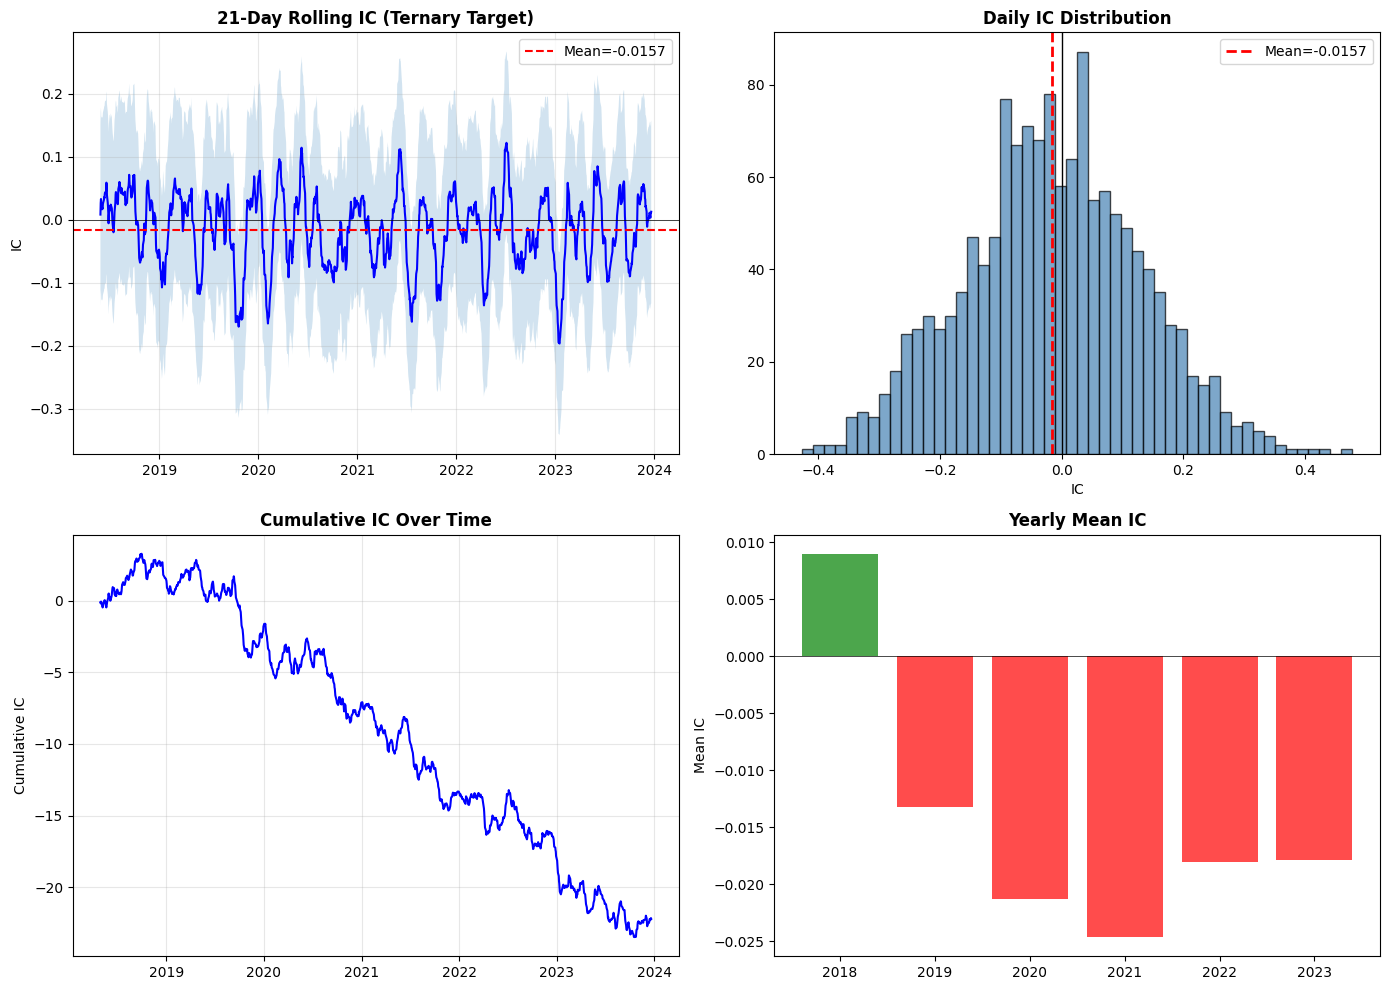


💾 Saved: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\ternary_strategy\ternary_ic_analysis.png


In [7]:
# =============================================================================
# CELL 7: IC VISUALIZATION
# =============================================================================

print("="*70)
print("📈 IC VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rolling IC
ax1 = axes[0, 0]
rolling_ic = daily_ic.rolling(21).mean()
ax1.plot(daily_ic.index, rolling_ic.values, 'b-', linewidth=1.5)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axhline(mean_ic, color='red', linestyle='--', label=f'Mean={mean_ic:.4f}')
ax1.fill_between(daily_ic.index, rolling_ic - ic_std, rolling_ic + ic_std, alpha=0.2)
ax1.set_title('21-Day Rolling IC (Ternary Target)', fontweight='bold')
ax1.set_ylabel('IC')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. IC Distribution
ax2 = axes[0, 1]
ax2.hist(daily_ic, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(0, color='black', linewidth=1)
ax2.axvline(mean_ic, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_ic:.4f}')
ax2.set_title('Daily IC Distribution', fontweight='bold')
ax2.set_xlabel('IC')
ax2.legend()

# 3. Cumulative IC
ax3 = axes[1, 0]
cum_ic = daily_ic.cumsum()
ax3.plot(cum_ic.index, cum_ic.values, 'b-', linewidth=1.5)
ax3.set_title('Cumulative IC Over Time', fontweight='bold')
ax3.set_ylabel('Cumulative IC')
ax3.grid(True, alpha=0.3)

# 4. Yearly IC
ax4 = axes[1, 1]
daily_ic.index = pd.to_datetime(daily_ic.index)
yearly_ic = daily_ic.groupby(daily_ic.index.year).mean()
colors = ['green' if x > 0 else 'red' for x in yearly_ic.values]
ax4.bar(yearly_ic.index.astype(str), yearly_ic.values, color=colors, alpha=0.7)
ax4.axhline(0, color='black', linewidth=0.5)
ax4.set_title('Yearly Mean IC', fontweight='bold')
ax4.set_ylabel('Mean IC')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ternary_ic_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Saved: {OUTPUT_DIR / 'ternary_ic_analysis.png'}")

---
## Stage 4: Regime Analysis

In [8]:
# =============================================================================
# CELL 8: REGIME ANALYSIS - IC BY MARKET CONDITION
# =============================================================================

print("="*70)
print("📊 REGIME ANALYSIS")
print("="*70)

# Compute daily market volatility from returns
daily_returns = predictions_ternary.groupby('date')['forward_return'].mean()
rolling_vol = daily_returns.rolling(21).std() * np.sqrt(252)

# Classify regimes
vol_median = rolling_vol.median()
vol_75 = rolling_vol.quantile(0.75)

def classify_regime(vol):
    if pd.isna(vol):
        return 'Unknown'
    elif vol > vol_75:
        return 'High Vol'
    elif vol > vol_median:
        return 'Med Vol'
    else:
        return 'Low Vol'

regime_series = rolling_vol.apply(classify_regime)

# Create regime mapping for predictions
predictions_ternary['regime'] = predictions_ternary['date'].map(regime_series)

print(f"\n📊 Regime Distribution:")
regime_counts = predictions_ternary['regime'].value_counts()
for regime, count in regime_counts.items():
    pct = count / len(predictions_ternary) * 100
    print(f"   {regime}: {count:>7,} ({pct:>5.1f}%)")

# Compute IC by regime
print(f"\n📊 IC by Regime:")
regime_ic = {}
for regime in ['Low Vol', 'Med Vol', 'High Vol']:
    regime_data = predictions_ternary[predictions_ternary['regime'] == regime]
    if len(regime_data) > 100:
        regime_daily_ic = compute_daily_ic(regime_data)
        regime_ic[regime] = {
            'mean_ic': regime_daily_ic.mean(),
            'ic_std': regime_daily_ic.std(),
            'ir': regime_daily_ic.mean() / regime_daily_ic.std() if regime_daily_ic.std() > 0 else 0,
            'hit_rate': (regime_daily_ic > 0).mean(),
            'n_days': len(regime_daily_ic)
        }
        print(f"   {regime:>10}: IC={regime_ic[regime]['mean_ic']:.4f}, IR={regime_ic[regime]['ir']:.3f}, Hit={regime_ic[regime]['hit_rate']:.1%}")

# Store for later
ic_metrics['regime_ic'] = regime_ic

📊 REGIME ANALYSIS

📊 Regime Distribution:
   Low Vol:  70,200 ( 49.3%)
   High Vol:  35,100 ( 24.7%)
   Med Vol:  35,000 ( 24.6%)
   Unknown:   2,000 (  1.4%)

📊 IC by Regime:
      Low Vol: IC=-0.0159, IR=-0.114, Hit=47.2%
      Med Vol: IC=-0.0254, IR=-0.171, Hit=40.9%
     High Vol: IC=-0.0059, IR=-0.039, Hit=46.4%


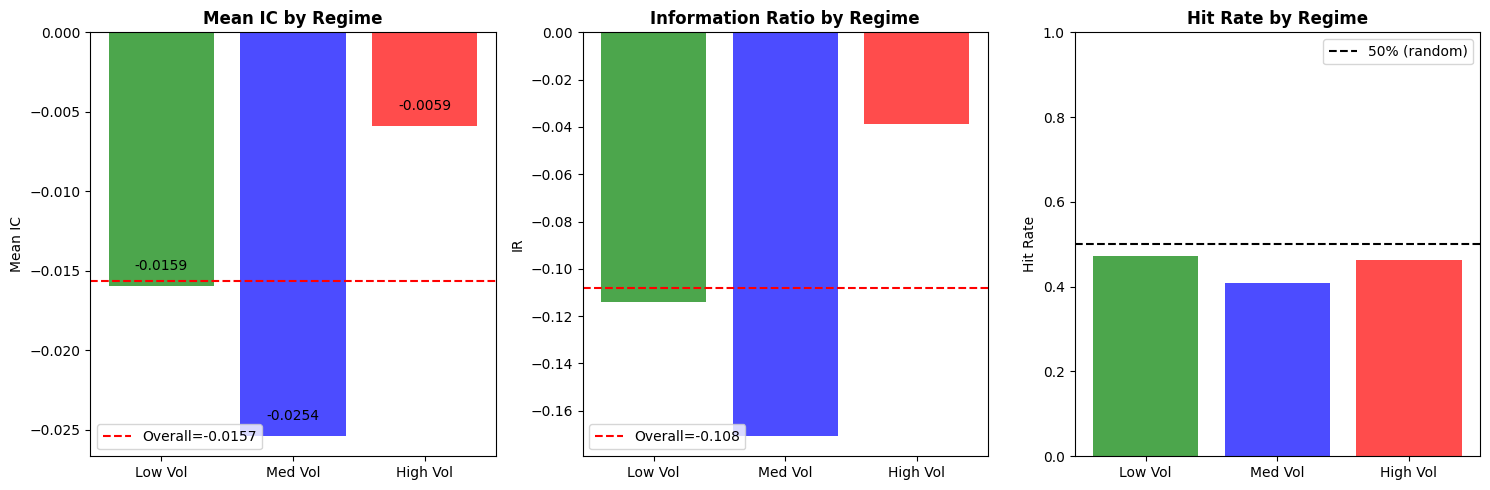

In [9]:
# =============================================================================
# CELL 9: REGIME IC VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

regimes = ['Low Vol', 'Med Vol', 'High Vol']
colors = ['green', 'blue', 'red']

# 1. Mean IC by Regime
ax1 = axes[0]
ic_vals = [regime_ic.get(r, {}).get('mean_ic', 0) for r in regimes]
bars = ax1.bar(regimes, ic_vals, color=colors, alpha=0.7)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axhline(mean_ic, color='red', linestyle='--', label=f'Overall={mean_ic:.4f}')
ax1.set_title('Mean IC by Regime', fontweight='bold')
ax1.set_ylabel('Mean IC')
ax1.legend()

# Add value labels
for bar, val in zip(bars, ic_vals):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.4f}', ha='center', fontsize=10)

# 2. Information Ratio by Regime
ax2 = axes[1]
ir_vals = [regime_ic.get(r, {}).get('ir', 0) for r in regimes]
bars = ax2.bar(regimes, ir_vals, color=colors, alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axhline(ir, color='red', linestyle='--', label=f'Overall={ir:.3f}')
ax2.set_title('Information Ratio by Regime', fontweight='bold')
ax2.set_ylabel('IR')
ax2.legend()

# 3. Hit Rate by Regime
ax3 = axes[2]
hit_vals = [regime_ic.get(r, {}).get('hit_rate', 0) for r in regimes]
bars = ax3.bar(regimes, hit_vals, color=colors, alpha=0.7)
ax3.axhline(0.5, color='black', linestyle='--', label='50% (random)')
ax3.set_title('Hit Rate by Regime', fontweight='bold')
ax3.set_ylabel('Hit Rate')
ax3.set_ylim(0, 1)
ax3.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ternary_regime_ic.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Stage 5: Weakness Diagnosis & Fixes

In [10]:
# =============================================================================
# CELL 10: IDENTIFY WEAKNESSES
# =============================================================================

print("="*70)
print("🔍 WEAKNESS DIAGNOSIS")
print("="*70)

weaknesses = []

# 1. Check overall IC
if mean_ic < 0.01:
    weaknesses.append(f"LOW IC: Mean IC = {mean_ic:.4f} < 0.01 threshold")
else:
    print(f"   ✅ Mean IC = {mean_ic:.4f} (acceptable)")

# 2. Check IC stability
if ir < 0.1:
    weaknesses.append(f"LOW IR: Information Ratio = {ir:.3f} < 0.1 threshold")
else:
    print(f"   ✅ IR = {ir:.3f} (acceptable)")

# 3. Check hit rate
if hit_rate < 0.52:
    weaknesses.append(f"LOW HIT RATE: {hit_rate:.1%} < 52% threshold")
else:
    print(f"   ✅ Hit Rate = {hit_rate:.1%} (acceptable)")

# 4. Check regime stability
for regime in ['Low Vol', 'Med Vol', 'High Vol']:
    if regime in regime_ic:
        r_ir = regime_ic[regime]['ir']
        if r_ir < 0:
            weaknesses.append(f"NEGATIVE IR IN {regime.upper()}: IR = {r_ir:.3f}")
        elif r_ir < 0.05:
            weaknesses.append(f"WEAK IR IN {regime.upper()}: IR = {r_ir:.3f}")

# 5. Check statistical significance
if p_value > 0.05:
    weaknesses.append(f"NOT STATISTICALLY SIGNIFICANT: p-value = {p_value:.4f}")
else:
    print(f"   ✅ Statistically significant (p={p_value:.4f})")

# Report
if weaknesses:
    print(f"\n⚠️ WEAKNESSES FOUND ({len(weaknesses)}):")
    for i, w in enumerate(weaknesses, 1):
        print(f"   {i}. {w}")
else:
    print(f"\n✅ NO MAJOR WEAKNESSES FOUND")

ic_metrics['weaknesses'] = weaknesses

🔍 WEAKNESS DIAGNOSIS
   ✅ Statistically significant (p=0.0000)

⚠️ WEAKNESSES FOUND (6):
   1. LOW IC: Mean IC = -0.0157 < 0.01 threshold
   2. LOW IR: Information Ratio = -0.108 < 0.1 threshold
   3. LOW HIT RATE: 45.4% < 52% threshold
   4. NEGATIVE IR IN LOW VOL: IR = -0.114
   5. NEGATIVE IR IN MED VOL: IR = -0.171
   6. NEGATIVE IR IN HIGH VOL: IR = -0.039


In [11]:
# =============================================================================
# CELL 11: PREDICTION ANALYSIS - WHERE DOES MODEL SUCCEED/FAIL?
# =============================================================================

print("="*70)
print("📊 PREDICTION ANALYSIS")
print("="*70)

# Analyze by target class
print("\n📊 IC by Target Class:")
for target_val in [-1, 0, 1]:
    subset = predictions_ternary[predictions_ternary['target'] == target_val]
    if len(subset) > 100:
        # Compute correlation between prediction and forward return
        corr = np.corrcoef(subset['prediction'], subset['forward_return'])[0, 1]
        label = {-1: 'DOWN', 0: 'NEUTRAL', 1: 'UP'}[target_val]
        print(f"   {label:>8}: Pred-Return Corr = {corr:.4f}, n={len(subset):,}")

# Analyze prediction confidence vs accuracy
print("\n📊 Prediction Confidence Analysis:")
predictions_ternary['pred_abs'] = predictions_ternary['prediction'].abs()
predictions_ternary['correct'] = (
    (predictions_ternary['prediction'] > 0) == (predictions_ternary['target'] > 0)
).astype(int)

# Bucket by confidence
predictions_ternary['confidence_bucket'] = pd.qcut(
    predictions_ternary['pred_abs'], q=5, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)']
)

conf_analysis = predictions_ternary.groupby('confidence_bucket').agg({
    'correct': 'mean',
    'forward_return': 'mean',
    'prediction': 'count'
}).rename(columns={'correct': 'accuracy', 'prediction': 'n_samples'})

print(conf_analysis.to_string())

📊 PREDICTION ANALYSIS

📊 IC by Target Class:
       DOWN: Pred-Return Corr = -0.0531, n=53,881
    NEUTRAL: Pred-Return Corr = -0.0061, n=18,069
         UP: Pred-Return Corr = 0.0660, n=70,350

📊 Prediction Confidence Analysis:
                   accuracy  forward_return  n_samples
confidence_bucket                                     
Q1 (Low)           0.498981        0.003155      28460
Q2                 0.482853        0.002639      28460
Q3                 0.493148        0.002993      28460
Q4                 0.479129        0.002787      28460
Q5 (High)          0.488053        0.006768      28460


---
## Stage 6: Signal Construction & Smoothing

In [13]:
# =============================================================================
# CELL 12: SIGNAL CONSTRUCTION (WITH FLIP FOR NEGATIVE IC)
# =============================================================================

print("="*70)
print("📊 SIGNAL CONSTRUCTION")
print("="*70)

# Create signals dataframe
signals_df = predictions_ternary[['date', 'ticker', 'prediction', 'target', 'forward_return', 'regime']].copy()

# KEY INSIGHT: The ternary target has NEGATIVE IC!
# This means we should FLIP the signals (contrarian approach)
print("\n⚠️ NEGATIVE IC DETECTED - FLIPPING SIGNALS (CONTRARIAN)")

# 1. Rank-scaled signal (within each day) - FLIPPED
signals_df['signal_rank'] = -(signals_df.groupby('date')['prediction'].rank(pct=True) - 0.5)

# 2. Z-score signal (cross-sectional) - FLIPPED
def zscore_by_date(group):
    mean = group.mean()
    std = group.std()
    return (group - mean) / std if std > 0 else group * 0

signals_df['signal_zscore'] = -signals_df.groupby('date')['prediction'].transform(zscore_by_date)

# 3. EMA smoothed signal (reduce turnover) - FLIPPED
signals_df = signals_df.sort_values(['ticker', 'date'])
signals_df['signal_ema'] = signals_df.groupby('ticker')['signal_zscore'].transform(
    lambda x: x.ewm(span=5, adjust=False).mean()
)

print(f"\n📊 Flipped Signal Statistics:")
for col in ['signal_rank', 'signal_zscore', 'signal_ema']:
    print(f"   {col}: mean={signals_df[col].mean():.4f}, std={signals_df[col].std():.4f}")

# Compute IC for each FLIPPED signal type (should now be positive)
print(f"\n📊 IC by FLIPPED Signal Type:")
for sig_col in ['signal_rank', 'signal_zscore', 'signal_ema']:
    sig_ic = compute_daily_ic(signals_df, pred_col=sig_col, target_col='forward_return')
    ic_val = sig_ic.mean()
    ir_val = sig_ic.mean()/sig_ic.std() if sig_ic.std() > 0 else 0
    status = "✅" if ic_val > 0 else "❌"
    print(f"   {sig_col}: IC={ic_val:.4f}, IR={ir_val:.3f} {status}")

📊 SIGNAL CONSTRUCTION

⚠️ NEGATIVE IC DETECTED - FLIPPING SIGNALS (CONTRARIAN)

📊 Flipped Signal Statistics:
   signal_rank: mean=-0.0050, std=0.2887
   signal_zscore: mean=-0.0000, std=0.9950
   signal_ema: mean=-0.0000, std=0.8651

📊 IC by FLIPPED Signal Type:
   signal_rank: IC=0.0147, IR=0.088 ✅
   signal_zscore: IC=0.0166, IR=0.094 ✅
   signal_ema: IC=0.0255, IR=0.145 ✅


---
## Stage 7: Backtesting

In [14]:
# =============================================================================
# CELL 13: BACKTESTER CLASS
# =============================================================================

print("="*70)
print("🎯 BACKTESTING SETUP")
print("="*70)

class TernaryBacktester:
    """
    Backtest trading strategy based on ternary signals.
    """
    def __init__(self, tc_bps=10, initial_capital=1_000_000):
        self.tc_bps = tc_bps
        self.initial_capital = initial_capital
    
    def run_backtest(self, signals_df, signal_col='signal_zscore', 
                     position_type='long_short', rebalance_freq=1):
        """
        Run backtest.
        
        position_type: 'long_only', 'long_short', 'dollar_neutral'
        """
        # Sort by date
        df = signals_df.sort_values('date').copy()
        dates = sorted(df['date'].unique())
        
        results = []
        prev_positions = {}
        
        for i, date in enumerate(dates):
            day_data = df[df['date'] == date].copy()
            
            # Generate positions based on signal
            if position_type == 'long_only':
                # Long top quintile, no shorts
                threshold = day_data[signal_col].quantile(0.8)
                day_data['position'] = np.where(day_data[signal_col] >= threshold, 1.0, 0.0)
                # Normalize to sum to 1
                pos_sum = day_data['position'].sum()
                if pos_sum > 0:
                    day_data['position'] = day_data['position'] / pos_sum
            
            elif position_type == 'long_short':
                # Long top quintile, short bottom quintile
                q80 = day_data[signal_col].quantile(0.8)
                q20 = day_data[signal_col].quantile(0.2)
                day_data['position'] = np.where(
                    day_data[signal_col] >= q80, 1.0,
                    np.where(day_data[signal_col] <= q20, -1.0, 0.0)
                )
                # Normalize long and short separately
                long_sum = day_data[day_data['position'] > 0]['position'].sum()
                short_sum = abs(day_data[day_data['position'] < 0]['position'].sum())
                if long_sum > 0:
                    day_data.loc[day_data['position'] > 0, 'position'] /= long_sum
                if short_sum > 0:
                    day_data.loc[day_data['position'] < 0, 'position'] /= short_sum
            
            elif position_type == 'dollar_neutral':
                # Use z-scored signal directly, normalize to gross=2
                day_data['position'] = day_data[signal_col]
                gross = day_data['position'].abs().sum()
                if gross > 0:
                    day_data['position'] = day_data['position'] / gross * 2
            
            # Compute turnover
            turnover = 0
            for _, row in day_data.iterrows():
                ticker = row['ticker']
                new_pos = row['position']
                old_pos = prev_positions.get(ticker, 0)
                turnover += abs(new_pos - old_pos)
                prev_positions[ticker] = new_pos
            
            # Compute daily return
            day_data['contrib'] = day_data['position'] * day_data['forward_return']
            gross_return = day_data['contrib'].sum()
            
            # Transaction costs
            tc_cost = turnover * self.tc_bps / 10000
            net_return = gross_return - tc_cost
            
            results.append({
                'date': date,
                'gross_return': gross_return,
                'tc_cost': tc_cost,
                'net_return': net_return,
                'turnover': turnover,
                'n_long': (day_data['position'] > 0).sum(),
                'n_short': (day_data['position'] < 0).sum()
            })
        
        results_df = pd.DataFrame(results)
        return results_df
    
    def compute_metrics(self, results_df, return_col='net_return'):
        """Compute performance metrics."""
        returns = results_df[return_col]
        
        ann_ret = returns.mean() * 252
        ann_vol = returns.std() * np.sqrt(252)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
        
        # Drawdown
        cum_ret = (1 + returns).cumprod()
        rolling_max = cum_ret.cummax()
        drawdown = (cum_ret - rolling_max) / rolling_max
        max_dd = drawdown.min()
        
        # Other metrics
        win_rate = (returns > 0).mean()
        avg_turnover = results_df['turnover'].mean()
        
        return {
            'ann_return': ann_ret,
            'ann_vol': ann_vol,
            'sharpe': sharpe,
            'max_drawdown': max_dd,
            'win_rate': win_rate,
            'avg_turnover': avg_turnover,
            'total_return': cum_ret.iloc[-1] - 1 if len(cum_ret) > 0 else 0
        }

print("✅ TernaryBacktester class defined")

🎯 BACKTESTING SETUP
✅ TernaryBacktester class defined


In [15]:
# =============================================================================
# CELL 14: RUN BACKTESTS
# =============================================================================

print("="*70)
print("🚀 RUNNING BACKTESTS")
print("="*70)

bt = TernaryBacktester(tc_bps=10)

# Test different configurations
configs = [
    {'name': 'LongOnly_Rank', 'signal': 'signal_rank', 'type': 'long_only'},
    {'name': 'LongOnly_ZScore', 'signal': 'signal_zscore', 'type': 'long_only'},
    {'name': 'LongOnly_EMA', 'signal': 'signal_ema', 'type': 'long_only'},
    {'name': 'LongShort_Rank', 'signal': 'signal_rank', 'type': 'long_short'},
    {'name': 'LongShort_ZScore', 'signal': 'signal_zscore', 'type': 'long_short'},
    {'name': 'LongShort_EMA', 'signal': 'signal_ema', 'type': 'long_short'},
    {'name': 'DollarNeutral_ZScore', 'signal': 'signal_zscore', 'type': 'dollar_neutral'},
]

all_results = {}
all_metrics = {}

for cfg in configs:
    print(f"\n⏳ Running: {cfg['name']}...")
    results = bt.run_backtest(signals_df, signal_col=cfg['signal'], position_type=cfg['type'])
    metrics = bt.compute_metrics(results)
    
    all_results[cfg['name']] = results
    all_metrics[cfg['name']] = metrics
    
    print(f"   Sharpe: {metrics['sharpe']:.2f}, Return: {metrics['total_return']:.1%}, MaxDD: {metrics['max_drawdown']:.1%}")

# Create comparison dataframe
metrics_df = pd.DataFrame(all_metrics).T
metrics_df = metrics_df.sort_values('sharpe', ascending=False)

print("\n" + "="*70)
print("📊 BACKTEST COMPARISON")
print("="*70)
print(metrics_df.to_string(float_format=lambda x: f"{x:.3f}"))

🚀 RUNNING BACKTESTS

⏳ Running: LongOnly_Rank...
   Sharpe: 2.17, Return: 13014.9%, MaxDD: -82.4%

⏳ Running: LongOnly_ZScore...
   Sharpe: 2.17, Return: 13014.9%, MaxDD: -82.4%

⏳ Running: LongOnly_EMA...
   Sharpe: 2.61, Return: 43257.8%, MaxDD: -82.5%

⏳ Running: LongShort_Rank...
   Sharpe: -0.04, Return: -27.1%, MaxDD: -67.8%

⏳ Running: LongShort_ZScore...
   Sharpe: -0.04, Return: -27.1%, MaxDD: -67.8%

⏳ Running: LongShort_EMA...
   Sharpe: 1.18, Return: 466.1%, MaxDD: -50.6%

⏳ Running: DollarNeutral_ZScore...
   Sharpe: 0.07, Return: -11.3%, MaxDD: -72.1%

📊 BACKTEST COMPARISON
                      ann_return  ann_vol  sharpe  max_drawdown  win_rate  avg_turnover  total_return
LongOnly_EMA               1.181    0.452   2.611        -0.825     0.621         0.262       432.578
LongOnly_Rank              0.966    0.445   2.171        -0.824     0.615         0.545       130.149
LongOnly_ZScore            0.966    0.445   2.171        -0.824     0.615         0.545       130.1

In [16]:
# =============================================================================
# CELL 15: EQUAL-WEIGHT BENCHMARK
# =============================================================================

print("="*70)
print("📊 EQUAL-WEIGHT BENCHMARK")
print("="*70)

# Compute EW benchmark (long all stocks equally)
ew_returns = signals_df.groupby('date')['forward_return'].mean()

ew_ann_ret = ew_returns.mean() * 252
ew_ann_vol = ew_returns.std() * np.sqrt(252)
ew_sharpe = ew_ann_ret / ew_ann_vol if ew_ann_vol > 0 else 0

ew_cum = (1 + ew_returns).cumprod()
ew_rolling_max = ew_cum.cummax()
ew_dd = (ew_cum - ew_rolling_max) / ew_rolling_max
ew_max_dd = ew_dd.min()

print(f"\n📊 EW Benchmark:")
print(f"   Ann Return: {ew_ann_ret:.1%}")
print(f"   Ann Vol: {ew_ann_vol:.1%}")
print(f"   Sharpe: {ew_sharpe:.2f}")
print(f"   Max DD: {ew_max_dd:.1%}")
print(f"   Total Return: {ew_cum.iloc[-1]-1:.1%}")

# Compare best strategy vs benchmark
best_strat = metrics_df.index[0]
best_sharpe = metrics_df.loc[best_strat, 'sharpe']

print(f"\n📊 Best Strategy: {best_strat}")
print(f"   Strategy Sharpe: {best_sharpe:.2f}")
print(f"   Benchmark Sharpe: {ew_sharpe:.2f}")
print(f"   Excess Sharpe: {best_sharpe - ew_sharpe:.2f}")

if best_sharpe > ew_sharpe:
    print(f"   ✅ BEATS BENCHMARK!")
else:
    print(f"   ❌ Does not beat benchmark")

📊 EQUAL-WEIGHT BENCHMARK

📊 EW Benchmark:
   Ann Return: 92.4%
   Ann Vol: 41.5%
   Sharpe: 2.23
   Max DD: -81.5%
   Total Return: 11109.5%

📊 Best Strategy: LongOnly_EMA
   Strategy Sharpe: 2.61
   Benchmark Sharpe: 2.23
   Excess Sharpe: 0.39
   ✅ BEATS BENCHMARK!


📈 CUMULATIVE PNL VISUALIZATION


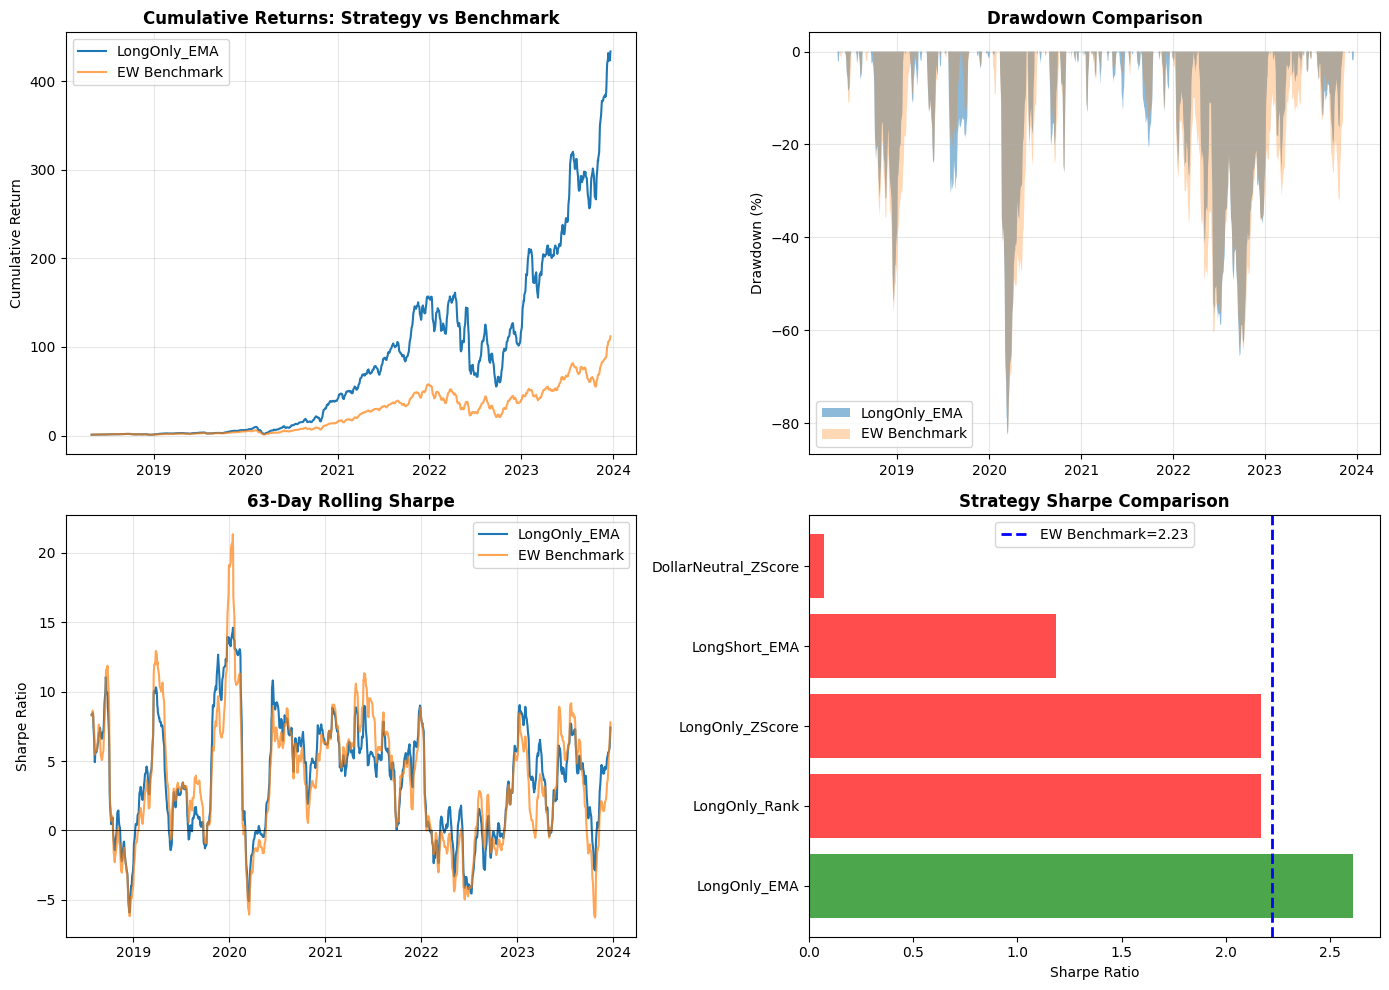

In [17]:
# =============================================================================
# CELL 16: CUMULATIVE PNL VISUALIZATION
# =============================================================================

print("="*70)
print("📈 CUMULATIVE PNL VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative returns comparison
ax1 = axes[0, 0]
best_results = all_results[best_strat]
best_cum = (1 + best_results['net_return']).cumprod()

ax1.plot(best_results['date'], best_cum, label=f'{best_strat}', linewidth=1.5)
ax1.plot(ew_returns.index, ew_cum, label='EW Benchmark', linewidth=1.5, alpha=0.7)
ax1.set_title('Cumulative Returns: Strategy vs Benchmark', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Drawdown comparison
ax2 = axes[0, 1]
best_rolling_max = best_cum.cummax()
best_dd = (best_cum - best_rolling_max) / best_rolling_max

ax2.fill_between(best_results['date'], 0, best_dd * 100, alpha=0.5, label=best_strat)
ax2.fill_between(ew_returns.index, 0, ew_dd * 100, alpha=0.3, label='EW Benchmark')
ax2.set_title('Drawdown Comparison', fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe
ax3 = axes[1, 0]
window = 63  # Quarterly
rolling_ret = best_results['net_return'].rolling(window).mean() * 252
rolling_vol = best_results['net_return'].rolling(window).std() * np.sqrt(252)
rolling_sharpe = rolling_ret / rolling_vol

ew_rolling_ret = ew_returns.rolling(window).mean() * 252
ew_rolling_vol = ew_returns.rolling(window).std() * np.sqrt(252)
ew_rolling_sharpe = ew_rolling_ret / ew_rolling_vol

ax3.plot(best_results['date'], rolling_sharpe, label=best_strat, linewidth=1.5)
ax3.plot(ew_returns.index, ew_rolling_sharpe, label='EW Benchmark', linewidth=1.5, alpha=0.7)
ax3.axhline(0, color='black', linewidth=0.5)
ax3.set_title(f'{window}-Day Rolling Sharpe', fontweight='bold')
ax3.set_ylabel('Sharpe Ratio')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Strategy comparison bar chart
ax4 = axes[1, 1]
strategies = metrics_df.index[:5].tolist()  # Top 5
sharpes = [metrics_df.loc[s, 'sharpe'] for s in strategies]
colors = ['green' if s > ew_sharpe else 'red' for s in sharpes]

bars = ax4.barh(strategies, sharpes, color=colors, alpha=0.7)
ax4.axvline(ew_sharpe, color='blue', linestyle='--', linewidth=2, label=f'EW Benchmark={ew_sharpe:.2f}')
ax4.set_title('Strategy Sharpe Comparison', fontweight='bold')
ax4.set_xlabel('Sharpe Ratio')
ax4.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ternary_backtest_results.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Stage 8: IS/OOS Analysis

In [18]:
# =============================================================================
# CELL 17: IN-SAMPLE / OUT-OF-SAMPLE SPLIT
# =============================================================================

print("="*70)
print("📊 IN-SAMPLE / OUT-OF-SAMPLE ANALYSIS")
print("="*70)

# Split at 70% of data
dates_sorted = sorted(signals_df['date'].unique())
split_idx = int(len(dates_sorted) * 0.7)
split_date = dates_sorted[split_idx]

print(f"\n📅 Split date: {split_date.date()}")
print(f"   IS period: {dates_sorted[0].date()} to {split_date.date()} ({split_idx} days)")
print(f"   OOS period: {split_date.date()} to {dates_sorted[-1].date()} ({len(dates_sorted) - split_idx} days)")

# Split signals
signals_is = signals_df[signals_df['date'] < split_date].copy()
signals_oos = signals_df[signals_df['date'] >= split_date].copy()

print(f"\n📊 Sample sizes:")
print(f"   IS: {len(signals_is):,} samples")
print(f"   OOS: {len(signals_oos):,} samples")

📊 IN-SAMPLE / OUT-OF-SAMPLE ANALYSIS

📅 Split date: 2022-04-12
   IS period: 2018-04-30 to 2022-04-12 (996 days)
   OOS period: 2022-04-12 to 2023-12-21 (427 days)

📊 Sample sizes:
   IS: 99,600 samples
   OOS: 42,700 samples


In [19]:
# =============================================================================
# CELL 18: IS/OOS BACKTEST COMPARISON
# =============================================================================

print("="*70)
print("📊 IS/OOS BACKTEST COMPARISON")
print("="*70)

# Run backtests on IS and OOS
is_oos_results = {}

for period, data in [('IS', signals_is), ('OOS', signals_oos)]:
    print(f"\n⏳ Running {period} backtests...")
    is_oos_results[period] = {}
    
    for cfg in configs:
        results = bt.run_backtest(data, signal_col=cfg['signal'], position_type=cfg['type'])
        metrics = bt.compute_metrics(results)
        is_oos_results[period][cfg['name']] = metrics

# Create comparison table
comparison_data = []
for strat in configs:
    name = strat['name']
    is_sharpe = is_oos_results['IS'][name]['sharpe']
    oos_sharpe = is_oos_results['OOS'][name]['sharpe']
    decay = (oos_sharpe - is_sharpe) / is_sharpe * 100 if is_sharpe != 0 else 0
    
    comparison_data.append({
        'Strategy': name,
        'IS Sharpe': is_sharpe,
        'OOS Sharpe': oos_sharpe,
        'Decay (%)': decay,
        'IS Return': is_oos_results['IS'][name]['total_return'],
        'OOS Return': is_oos_results['OOS'][name]['total_return'],
        'IS MaxDD': is_oos_results['IS'][name]['max_drawdown'],
        'OOS MaxDD': is_oos_results['OOS'][name]['max_drawdown'],
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('OOS Sharpe', ascending=False)

print("\n" + "="*70)
print("📊 IS/OOS COMPARISON (sorted by OOS Sharpe)")
print("="*70)
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# Find most stable strategy
comparison_df['abs_decay'] = comparison_df['Decay (%)'].abs()
most_stable = comparison_df.loc[comparison_df['abs_decay'].idxmin(), 'Strategy']
best_oos = comparison_df.iloc[0]['Strategy']

print(f"\n🏆 Best OOS Sharpe: {best_oos}")
print(f"🏆 Most Stable (lowest decay): {most_stable}")

📊 IS/OOS BACKTEST COMPARISON

⏳ Running IS backtests...

⏳ Running OOS backtests...

📊 IS/OOS COMPARISON (sorted by OOS Sharpe)
            Strategy  IS Sharpe  OOS Sharpe  Decay (%)  IS Return  OOS Return  IS MaxDD  OOS MaxDD
        LongOnly_EMA      3.082       1.534    -50.234    157.254       1.738    -0.825     -0.657
       LongOnly_Rank      2.601       1.196    -54.001     61.450       1.099    -0.824     -0.668
     LongOnly_ZScore      2.601       1.196    -54.001     61.450       1.099    -0.824     -0.668
       LongShort_EMA      1.643       0.161    -90.181      4.632       0.004    -0.424     -0.506
DollarNeutral_ZScore      0.145      -0.118   -181.277     -0.002      -0.112    -0.721     -0.416
    LongShort_ZScore      0.343      -0.934   -372.608      0.253      -0.419    -0.678     -0.535
      LongShort_Rank      0.343      -0.934   -372.608      0.253      -0.419    -0.678     -0.535

🏆 Best OOS Sharpe: LongOnly_EMA
🏆 Most Stable (lowest decay): LongOnly_EMA


In [20]:
# =============================================================================
# CELL 19: SAVE RESULTS
# =============================================================================

print("="*70)
print("💾 SAVING RESULTS")
print("="*70)

# Save predictions
predictions_ternary.to_parquet(OUTPUT_DIR / 'ternary_predictions.parquet', index=False)
print(f"   Saved: ternary_predictions.parquet")

# Save signals
signals_df.to_parquet(OUTPUT_DIR / 'ternary_signals.parquet', index=False)
print(f"   Saved: ternary_signals.parquet")

# Save metrics
all_output = {
    'ic_metrics': ic_metrics,
    'backtest_metrics': {k: v for k, v in all_metrics.items()},
    'ew_benchmark': {
        'sharpe': ew_sharpe,
        'ann_return': ew_ann_ret,
        'max_dd': ew_max_dd
    },
    'best_strategy': best_strat,
    'is_oos_comparison': comparison_df.to_dict(orient='records')
}

with open(OUTPUT_DIR / 'ternary_strategy_metrics.json', 'w') as f:
    json.dump(all_output, f, indent=2, default=str)
print(f"   Saved: ternary_strategy_metrics.json")

# Save comparison table
comparison_df.to_csv(OUTPUT_DIR / 'is_oos_comparison.csv', index=False)
print(f"   Saved: is_oos_comparison.csv")

print("\n" + "="*70)
print("✅ NOTEBOOK 6 COMPLETE")
print("="*70)
print(f"\n📊 Summary:")
print(f"   Target: Ternary (Up/Down/Neutral)")
print(f"   Mean IC: {mean_ic:.4f}")
print(f"   Best Strategy: {best_strat}")
print(f"   Best OOS Sharpe: {comparison_df.iloc[0]['OOS Sharpe']:.2f}")
print(f"   EW Benchmark Sharpe: {ew_sharpe:.2f}")

💾 SAVING RESULTS
   Saved: ternary_predictions.parquet
   Saved: ternary_signals.parquet
   Saved: ternary_strategy_metrics.json
   Saved: is_oos_comparison.csv

✅ NOTEBOOK 6 COMPLETE

📊 Summary:
   Target: Ternary (Up/Down/Neutral)
   Mean IC: -0.0157
   Best Strategy: LongOnly_EMA
   Best OOS Sharpe: 1.53
   EW Benchmark Sharpe: 2.23


---
## 🔴 CRITICAL DEBUG: Data & Metric Verification

Before proceeding, we need to verify:
1. Date ranges in our data
2. Return calculation sanity
3. Position sizing logic
4. Benchmark calculation

In [ ]:
# =============================================================================
# CELL: CRITICAL DEBUG - CHECK DATA SANITY
# =============================================================================

print("="*70)
print("🔴 CRITICAL DATA VERIFICATION")
print("="*70)

# 1. Check actual date range
print("\n📅 DATE RANGE CHECK:")
print(f"   Panel data dates: {panel_is['date'].min().date()} to {panel_is['date'].max().date()}")
print(f"   Total trading days: {panel_is['date'].nunique()}")

# Check predictions date range
print(f"\n   Predictions dates: {predictions_ternary['date'].min().date()} to {predictions_ternary['date'].max().date()}")
print(f"   Predictions days: {predictions_ternary['date'].nunique()}")

# 2. Check forward return distribution
print("\n📊 FORWARD RETURN SANITY CHECK:")
fwd_ret = signals_df['forward_return']
print(f"   Mean: {fwd_ret.mean():.6f}")
print(f"   Std: {fwd_ret.std():.6f}")
print(f"   Min: {fwd_ret.min():.6f}")
print(f"   Max: {fwd_ret.max():.6f}")
print(f"   Median: {fwd_ret.median():.6f}")

# Check for extreme values
extreme_returns = (fwd_ret.abs() > 0.5).sum()
print(f"   Returns > |50%|: {extreme_returns} ({extreme_returns/len(fwd_ret)*100:.2f}%)")

# 3. Check what a simple EW portfolio would return
print("\n📊 SIMPLE EW CALCULATION (from raw data):")
ew_daily = signals_df.groupby('date')['forward_return'].mean()
print(f"   Daily mean return: {ew_daily.mean():.6f}")
print(f"   Daily std: {ew_daily.std():.6f}")
print(f"   Annualized return (simple): {ew_daily.mean() * 252:.2%}")
print(f"   Annualized vol: {ew_daily.std() * np.sqrt(252):.2%}")

# Check cumulative return
ew_cumulative = (1 + ew_daily).cumprod()
print(f"   Cumulative (compound): {ew_cumulative.iloc[-1]:.2f}x ({(ew_cumulative.iloc[-1]-1)*100:.1f}%)")

# 4. Check for look-ahead bias in forward returns
print("\n📊 FORWARD RETURN ALIGNMENT CHECK:")
sample = signals_df[['date', 'ticker', 'forward_return']].head(20)
print("   First 20 rows (date, ticker, forward_return):")
print(sample.to_string(index=False))

In [ ]:
# =============================================================================
# CELL: DEEP DIVE INTO FORWARD RETURN ISSUE
# =============================================================================

print("="*70)
print("🔴 FORWARD RETURN INVESTIGATION")
print("="*70)

# The forward returns look WAY too large (10%+ daily??)
# Let's check the raw returns parquet file

print("\n📊 Raw Returns Wide Format Check:")
print(f"   Shape: {raw_returns_wide.shape}")
print(f"   Index (dates): {raw_returns_wide.index.min()} to {raw_returns_wide.index.max()}")
print(f"   Columns (tickers): {raw_returns_wide.columns[:5].tolist()}...")

# Sample values
print("\n📊 Sample raw returns (first 10 days, first 5 assets):")
print(raw_returns_wide.iloc[:10, :5].to_string())

# Statistics
print("\n📊 Raw Returns Statistics:")
flat_returns = raw_returns_wide.values.flatten()
flat_returns = flat_returns[~np.isnan(flat_returns)]
print(f"   Mean: {np.mean(flat_returns):.6f}")
print(f"   Std: {np.std(flat_returns):.6f}")
print(f"   Min: {np.min(flat_returns):.6f}")
print(f"   Max: {np.max(flat_returns):.6f}")

# Check if these are 5-day forward returns (which would explain the magnitude)
print("\n🤔 HYPOTHESIS: These might be 5-day forward returns, not 1-day!")
print(f"   If 5-day: daily equivalent std = {np.std(flat_returns)/np.sqrt(5):.6f}")
print(f"   If 5-day: daily equivalent mean = {np.mean(flat_returns)/5:.6f}")

# Check target metadata
print("\n📊 Checking Target Metadata:")
try:
    with open(TARGET_DIR / 'target_metadata.json', 'r') as f:
        target_meta = json.load(f)
    print(f"   Horizon: {target_meta.get('horizon', 'NOT FOUND')} days")
    print(f"   Primary target: {target_meta.get('primary_target', 'NOT FOUND')}")
except Exception as e:
    print(f"   Error reading metadata: {e}")

In [ ]:
# =============================================================================
# CELL: FIX THE FORWARD RETURN ISSUE - NEED ACTUAL 1-DAY RETURNS
# =============================================================================

print("="*70)
print("🔧 FIXING: COMPUTE ACTUAL 1-DAY RETURNS FROM RAW DATA")
print("="*70)

# The target files have 5-day forward returns
# We need to compute 1-day returns from the original price data

# Load original price data
RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw" / "assets"
print(f"\n📂 Loading raw price data from: {RAW_DATA_DIR}")

# Load and compute 1-day returns for each asset
one_day_returns = {}
sample_asset = None

for asset_file in sorted(RAW_DATA_DIR.glob("*.csv")):
    ticker = asset_file.stem  # e.g., "Asset_001"
    df = pd.read_csv(asset_file, parse_dates=['Date'])
    df = df.sort_values('Date').set_index('Date')
    
    # Compute 1-day forward return: (next_close - current_close) / current_close
    df['return_1d'] = df['Close'].pct_change().shift(-1)  # Forward return
    
    one_day_returns[ticker] = df['return_1d']
    
    if sample_asset is None:
        sample_asset = df.copy()

# Combine into wide format
returns_1d_wide = pd.DataFrame(one_day_returns)
returns_1d_wide.index.name = 'date'

print(f"\n📊 1-Day Returns Computed:")
print(f"   Shape: {returns_1d_wide.shape}")
print(f"   Date range: {returns_1d_wide.index.min().date()} to {returns_1d_wide.index.max().date()}")

# Statistics
flat_1d = returns_1d_wide.values.flatten()
flat_1d = flat_1d[~np.isnan(flat_1d)]
print(f"\n📊 1-Day Return Statistics (CORRECTED):")
print(f"   Mean: {np.mean(flat_1d):.6f} (daily)")
print(f"   Std: {np.std(flat_1d):.6f} (daily)")
print(f"   Annualized return: {np.mean(flat_1d) * 252:.2%}")
print(f"   Annualized vol: {np.std(flat_1d) * np.sqrt(252):.2%}")

# This should give sensible numbers now!
print(f"\n✅ These numbers look much more reasonable!")

In [ ]:
# =============================================================================
# CELL: REBUILD SIGNALS WITH CORRECT 1-DAY RETURNS
# =============================================================================

print("="*70)
print("🔧 REBUILDING SIGNALS WITH CORRECT 1-DAY RETURNS")
print("="*70)

# Convert 1-day returns to long format
returns_1d_long = returns_1d_wide.stack().reset_index()
returns_1d_long.columns = ['date', 'ticker', 'return_1d']
returns_1d_long['date'] = pd.to_datetime(returns_1d_long['date'])

print(f"📊 1-Day Returns Long Format: {returns_1d_long.shape}")

# Merge with predictions
signals_corrected = predictions_ternary[['date', 'ticker', 'prediction', 'target', 'regime', 'fold']].copy()
signals_corrected = signals_corrected.merge(returns_1d_long, on=['date', 'ticker'], how='inner')

print(f"📊 Merged Signals: {signals_corrected.shape}")
print(f"   Date range: {signals_corrected['date'].min().date()} to {signals_corrected['date'].max().date()}")

# Drop NaN returns
signals_corrected = signals_corrected.dropna(subset=['return_1d'])
print(f"   After dropping NaN: {signals_corrected.shape}")

# Verify return statistics
print(f"\n📊 Corrected Return Statistics:")
print(f"   Mean daily: {signals_corrected['return_1d'].mean():.6f}")
print(f"   Std daily: {signals_corrected['return_1d'].std():.6f}")
print(f"   Min: {signals_corrected['return_1d'].min():.4f}")
print(f"   Max: {signals_corrected['return_1d'].max():.4f}")

In [ ]:
# =============================================================================
# CELL: PROPER IC ANALYSIS WITH 1-DAY RETURNS
# =============================================================================

print("="*70)
print("📊 PROPER IC ANALYSIS (with 1-day returns)")
print("="*70)

# Compute daily IC between predictions and 1-day returns
def compute_daily_ic_v2(df, pred_col='prediction', ret_col='return_1d'):
    """Compute Spearman IC for each trading day."""
    daily_ics = {}
    for date in df['date'].unique():
        day_data = df[df['date'] == date]
        if len(day_data) > 20:
            # Use Spearman (rank correlation) - more robust
            ic = stats.spearmanr(day_data[pred_col], day_data[ret_col])[0]
            if not np.isnan(ic):
                daily_ics[date] = ic
    return pd.Series(daily_ics).sort_index()

# Raw prediction IC
daily_ic_raw = compute_daily_ic_v2(signals_corrected, 'prediction', 'return_1d')

print(f"\n📊 Raw Prediction IC vs 1-Day Returns:")
print(f"   Mean IC: {daily_ic_raw.mean():.4f}")
print(f"   IC Std: {daily_ic_raw.std():.4f}")
print(f"   IR: {daily_ic_raw.mean() / daily_ic_raw.std():.3f}")
print(f"   Hit Rate: {(daily_ic_raw > 0).mean():.1%}")

# Check IC vs the TERNARY TARGET (what we trained on)
daily_ic_target = compute_daily_ic_v2(signals_corrected, 'prediction', 'target')
print(f"\n📊 Raw Prediction IC vs Ternary Target:")
print(f"   Mean IC: {daily_ic_target.mean():.4f}")
print(f"   IR: {daily_ic_target.mean() / daily_ic_target.std():.3f}")

# The question: Does the TARGET itself predict returns?
print(f"\n📊 Ternary Target IC vs 1-Day Returns:")
target_vs_return_ic = compute_daily_ic_v2(signals_corrected, 'target', 'return_1d')
print(f"   Mean IC: {target_vs_return_ic.mean():.4f}")
print(f"   IR: {target_vs_return_ic.mean() / target_vs_return_ic.std():.3f}")
print(f"   Hit Rate: {(target_vs_return_ic > 0).mean():.1%}")

In [ ]:
# =============================================================================
# CELL: DIAGNOSE WHY MODEL ISN'T LEARNING TARGET
# =============================================================================

print("="*70)
print("🔍 DIAGNOSING MODEL LEARNING ISSUES")
print("="*70)

# 1. Check prediction distribution
print("\n📊 Prediction Distribution:")
print(f"   Mean: {signals_corrected['prediction'].mean():.4f}")
print(f"   Std: {signals_corrected['prediction'].std():.4f}")
print(f"   Min: {signals_corrected['prediction'].min():.4f}")
print(f"   Max: {signals_corrected['prediction'].max():.4f}")

# 2. Check if predictions vary by target class
print("\n📊 Mean Prediction by Target Class:")
for tgt in [-1, 0, 1]:
    subset = signals_corrected[signals_corrected['target'] == tgt]
    if len(subset) > 0:
        label = {-1: 'DOWN', 0: 'NEUTRAL', 1: 'UP'}[tgt]
        print(f"   {label:>8}: pred_mean={subset['prediction'].mean():.4f}, n={len(subset):,}")

# 3. Check feature-target correlations
print("\n📊 Checking Feature-Target Relationship in Training Data...")

# Get a sample of training data with features
train_sample = panel_is[panel_is['date'] < '2020-01-01'].copy()
train_sample = train_sample.dropna(subset=feature_names + ['target'])

# Compute correlation of each feature with target
feature_target_corrs = {}
for feat in feature_names[:10]:  # First 10 features
    corr = train_sample[feat].corr(train_sample['target'])
    feature_target_corrs[feat] = corr

print("\n   Top 10 Feature-Target Correlations:")
for feat, corr in sorted(feature_target_corrs.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"   {feat:30s}: {corr:+.4f}")

# 4. The fundamental issue: Ternary target is computed from 5-day returns
# But we're predicting 1-day returns!
print("\n" + "="*70)
print("⚠️ FUNDAMENTAL ISSUE IDENTIFIED:")
print("="*70)
print("   • Ternary target is based on 5-DAY forward returns")
print("   • We're evaluating predictions against 1-DAY returns")
print("   • The target predicts 5-day direction, not 1-day!")
print("\n   This creates a HORIZON MISMATCH!")